**ogs@jupyter-lab Reactive transport of Cs in diffusion-controlled conditions**

<table><tr>
<td> <img src="../ogs-workflows.png" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="../icross-logo-ok.png" alt="Drawing" style="width: 100px;"/> </td>
</tr></table>

In OGS, a reactive transport simulation is enabled by adding the keyword `<chemical_system>`:
```XML
    <chemical_system chemical_solver="Phreeqc">
        <mesh>ReactiveDomain_opa_ics</mesh>
        <database>ThermoChimie_PHREEQC_Davies_electron_v9b0_noCsCl_with_sorption.dat</database>
        <linear_solver>general_linear_solver</linear_solver>
        <solution>
            <temperature>25</temperature>
            <pressure>1</pressure>
            <pe>-2</pe>
            <components>
                <component>C(4)</component>
                <component>Ca</component>
                <component>Cl</component>
                <component>Cs</component>
                <component>K</component>
                <component>Mg</component>
                <component>Na</component>
                <component>S(6)</component>
                <component>Sr</component>
            </components>
        </solution>
        <surface site_unit="mole">
            <site>
                <name>Su_</name>
            </site>
            <site>
                <name>Su_fes</name>
            </site>
            <site>
                <name>Su_ii</name>
            </site>
        </surface>
        <knobs>
            <max_iter>500</max_iter>
            <relative_convergence_tolerance>1e-13</relative_convergence_tolerance>
            <tolerance>1e-15</tolerance>
            <step_size>100</step_size>
            <scaling>0</scaling>
        </knobs>
    </chemical_system>
```

In this setup, three sorption sites are being added to the model (from Phreeqc-format database `ThermoChimie_PHREEQC_Davies_electron_v9b0_noCsCl_with_sorption.dat`). However, the amount of sorption sites has to be passed to OGS as a media component in the solid phase (under the `<media>/<medium>/<phase>/<type>Solid</type>`). For instance, the `Su_` site amount in moles is added as follows:

```XML
<phase>
    <type>Solid</type>
    <components>
        <component>
            <name>Su_</name>
            <properties>
                <property>
                    <name>molality</name>
                    <type>Constant</type>
                    <value>1.4250e+00</value>
                </property>
            </properties>
        </component>
        ...
```

                  

The file `caesium.prj` already contains the chemical system definition and site quantities. First, validate the `caesium.prj` file:

In [4]:
!xmllint --noout caesium.prj

Then, run the ogs model with `ogs6py`.

### ***1) OGS pre-processing utilities***

An extra utility is used for the reactive transport case. The `identifySubdomains` tool is used to create a "reactive" mesh. The utility should be used after `GMSH2OGS` and `NodeReordering`. 


In [18]:
import os
mesh = "opa"
os.system("GMSH2OGS -e -i {}.msh -o {}.vtu".format(mesh, mesh))
os.system("NodeReordering -i {}.vtu -o {}.vtu".format(mesh, mesh))
os.system("constructMeshesFromGeometry -m {}.vtu -g {}.gml -s 1e-6".format(mesh, mesh))
# OGS utility to create reactive mesh:
os.system("identifySubdomains -m {}.vtu -o ReactiveDomain_ -- {}.vtu".format(mesh, mesh))

[2021-11-24 16:10:15.274] [ogs] [info] Reading opa.msh.
[2021-11-24 16:10:15.275] [ogs] [info] 	... finished.
[2021-11-24 16:10:15.275] [ogs] [info] Nr. Nodes: 51.
[2021-11-24 16:10:15.275] [ogs] [info] Nr. Elements: 50.
[2021-11-24 16:10:15.275] [ogs] [info] Mem for mesh: 0 MiB
[2021-11-24 16:10:15.275] [ogs] [info] Time for reading: 0.000172 seconds.
[2021-11-24 16:10:15.275] [ogs] [info] Read 51 nodes and 50 elements.
[2021-11-24 16:10:15.275] [ogs] [info] Removing total 50 elements...
[2021-11-24 16:10:15.275] [ogs] [info] 0 elements remain in mesh.
[2021-11-24 16:10:15.275] [ogs] [info] Removing total 51 nodes...
[2021-11-24 16:10:15.275] [ogs] [info] Current selection removes all elements.
[2021-11-24 16:10:15.275] [ogs] [info] Mesh does not contain any lines.
[2021-11-24 16:10:15.275] [ogs] [info] Please check your mesh carefully!
[2021-11-24 16:10:15.275] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2021-11-24 16:10:15.275] [ogs] [inf

0

### ***2) Run OGS-6#iPHREEQC with `ogs6py`***

**Note:** The simulation takes about 2.5 hours!

In [21]:
from ogs6py import ogs
model = ogs.OGS(PROJECT_FILE="caesium.prj")
print(">>> model running <<<")
#os.system("mkdir output")
model.run_model(write_logs=False, args="-o ./output")

>>> model running <<<
OGS finished with project file caesium.prj.
Execution took 8612.845652103424 s


### ***3) Model output***

>>> print results <<<


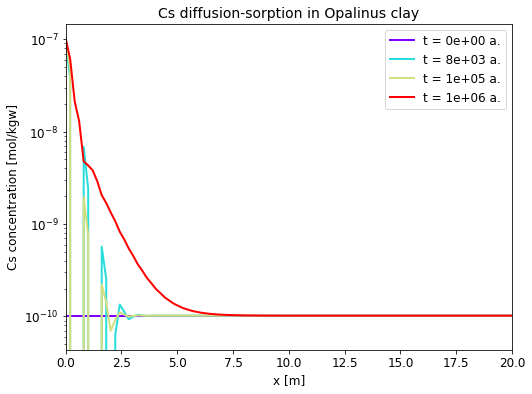

In [49]:
import vtuIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

plt.style.use('../notebook.mplstyle')
print(">>> print results <<<")

pvdfile=vtuIO.PVDIO("./output/out.pvd", dim=1)
xaxis =  [(i,0,0) for i in np.linspace(start=0.0, stop=20, num=100)]
r_x = np.array(xaxis)[:,0]
time_pvd = pvdfile.timesteps

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

time = [
    find_nearest(time_pvd, 0),
    find_nearest(time_pvd, 3.1536e11),
    find_nearest(time_pvd, 3.1536e12),
    find_nearest(time_pvd, 3.1536e13)
]

color=iter(cm.rainbow(np.linspace(0,1,len(time))))
for t, color in zip(time, color):
    y = pvdfile.read_set_data(t, 'Cs', pointsetarray=xaxis)
    plt.plot(r_x, y, label='t = {:.0e} a.'.format(t/365/3600/24), color=color, linestyle="-")
    
plt.yscale("log")
plt.title("Cs diffusion-sorption in Opalinus clay")
plt.xlim(0,20)
plt.xlabel('x [m]')
plt.ylabel('Cs concentration [mol/kgw]')

plt.legend()
plt.show()

### ***4) Non-uniform mesh setup***

It is worth exploring if the oscillations produced due to the high concentration gradient at the inlet boundary can be mitigated. One possible solution is to use a mesh with smaller elements at the boundary. This can be done in `GMSH` using a `Transfinite Line` (see file `opa-progressive.geo`).  

In [46]:
import os
mesh = "opa-progressive"
os.system("GMSH2OGS -e -i {}.msh -o {}.vtu".format(mesh, mesh))
os.system("NodeReordering -i {}.vtu -o {}.vtu".format(mesh, mesh))
os.system("identifySubdomains -m {}.vtu -o ReactiveDomain_ -- {}.vtu".format(mesh, mesh))

[2021-11-25 09:08:12.792] [ogs] [info] Reading opa-progressive.msh.
[2021-11-25 09:08:12.793] [ogs] [info] 	... finished.
[2021-11-25 09:08:12.793] [ogs] [info] Nr. Nodes: 51.
[2021-11-25 09:08:12.793] [ogs] [info] Nr. Elements: 50.
[2021-11-25 09:08:12.793] [ogs] [info] Mem for mesh: 0 MiB
[2021-11-25 09:08:12.793] [ogs] [info] Time for reading: 0.000280 seconds.
[2021-11-25 09:08:12.793] [ogs] [info] Read 51 nodes and 50 elements.
[2021-11-25 09:08:12.793] [ogs] [info] Removing total 50 elements...
[2021-11-25 09:08:12.793] [ogs] [info] 0 elements remain in mesh.
[2021-11-25 09:08:12.793] [ogs] [info] Removing total 51 nodes...
[2021-11-25 09:08:12.793] [ogs] [info] Current selection removes all elements.
[2021-11-25 09:08:12.793] [ogs] [info] Mesh does not contain any lines.
[2021-11-25 09:08:12.793] [ogs] [info] Please check your mesh carefully!
[2021-11-25 09:08:12.793] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2021-11-25 09:08:12.793

0

The project file `caesium-progressive.prj` uses the new mesh setup. Note that this setup uses the same number of elements, therefore, the computation cost should not increase. 

In [8]:
from ogs6py import ogs
model_progressive = ogs.OGS(PROJECT_FILE="caesium-progressive.prj")
print(">>> model running <<<")
model_progressive.run_model(write_logs=False, args="-o ./output")

>>> model running <<<
OGS finished with project file caesium-progressive.prj.
Execution took 8578.984436035156 s


Then results can be compared:

>>> print results <<<


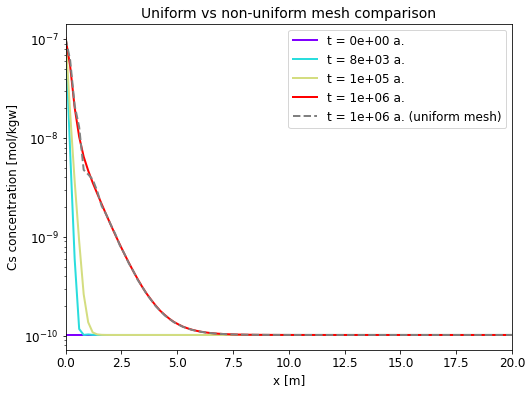

In [48]:
print(">>> print results <<<")

pvdfile_fine=vtuIO.PVDIO("./output/outProgressive.pvd", dim=1)
time_pvd = pvdfile.timesteps

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

time = [
    find_nearest(time_pvd, 0),
    find_nearest(time_pvd, 3.1536e11),
    find_nearest(time_pvd, 3.1536e12),
    find_nearest(time_pvd, 3.1536e13)
]

color=iter(cm.rainbow(np.linspace(0,1,len(time))))
for t, color in zip(time, color):
    y_fine = pvdfile_fine.read_set_data(t, 'Cs', pointsetarray=xaxis)
    plt.plot(r_x, y_fine, label='t = {:.0e} a.'.format(t/365/3600/24), color=color, linestyle="-")

y = pvdfile.read_set_data(time[-1], 'Cs', pointsetarray=xaxis)
plt.plot(r_x, y, label='t = {:.0e} a. (uniform mesh)'.format(t/365/3600/24), color='gray', linestyle="--")
    
plt.yscale("log")
plt.title("Uniform vs non-uniform mesh comparison")
plt.xlim(0,20)
plt.xlabel('x [m]')
plt.ylabel('Cs concentration [mol/kgw]')

plt.legend()
plt.show()